In [1]:
import numpy as np
import h5py
import os

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import matplotlib as mpl
mpl.rcParams['font.size']=16
mpl.rcParams['font.serif'] = "Bitstream Vera Serif"
mpl.rcParams['font.family'] = "serif"

from numpy import polyfit, polyval
from numpy.polynomial.legendre import legfit, legval

In [2]:

def normalize(d):
    x=d.copy()
    x-=x.min()
    return x/(x.max()-x.min())

In [3]:
run_num = 119
f=h5py.File('/reg/d/psdm/cxi/cxilr6716/scratch/kmeans_clusters/cali_gai/pca10_kmeans15/run%d_clustered_shots.h5'%run_num,'r')
qidx = 10
print f['q%d'%qidx].keys()

f_eig=h5py.File('/reg/d/psdm/cxi/cxilr6716/scratch/kmeans_clusters/cali_gai/pca10_kmeans15/run%d_eigenimages.h5'%run_num,'r')

phi_offset = 15
num_phi = f['q10']['norm_shots_0'].shape[-1]
qvalue = np.load('/reg/neh/home/qiaoshen/run16_notebooks/encodeZ400_qvalue.npy')[10:33]
exp_cpsi = np.load('/reg/neh/home/qiaoshen/run16_notebooks/encodeZ400_cpsi.npy')[:,phi_offset:num_phi/2-phi_offset]

[u'asym', u'ave_clus_cor', u'ave_cor', u'clus_nshots', u'norm_shots_0', u'norm_shots_1', u'norm_shots_10', u'norm_shots_11', u'norm_shots_12', u'norm_shots_13', u'norm_shots_14', u'norm_shots_2', u'norm_shots_3', u'norm_shots_4', u'norm_shots_5', u'norm_shots_6', u'norm_shots_7', u'norm_shots_8', u'norm_shots_9']


In [21]:
denoised_cors =[]
pca_num = []
pca_asyms =[]
cluster_asyms = []
for qidx in range(10,32):
    ##### comput asymetries of cluster average
#     print qidx
    cluster_nums =sorted([ int(key.split('_')[-1]) for key in f['q%d'%qidx].keys() if key.startswith('norm')])
    asym_kmeans = f['q%d'%qidx]['asym'].value
    cluster_asyms.append(asym_kmeans)
    all_asym=[]
    for jj,kk in enumerate(cluster_nums):
#         print kk
        asym=[asym_kmeans[jj]]
        for ii in range(1,15):
            try:
                cc= f_eig['q%d'%qidx]['k%d'%kk]['pca%d'%ii][0,phi_offset:num_phi/2-phi_offset]
                nc=normalize(cc)
                asym.append( (np.abs(nc-nc[::-1])).mean() )
            except:
                asym.append(10000)
        all_asym.append(asym)
    all_asym=np.array(all_asym)
    pca_asyms.append(all_asym)
    ##### use the minimum asymmetry to decide what pcs components to remove for each cluster
    remove=all_asym.argmin(-1)

    ave_cor =None
    num_shots=0
    for jj,kk in enumerate(cluster_nums):
        if remove[jj]>1:
    #         cc= f_eig['q%d'%qidx]['k%d'%kk]['pca2'][0,phi_offset:num_phi/2-phi_offset]
            cc= f_eig['q%d'%qidx]['k%d'%kk]['pca%d'%remove[jj]][0,phi_offset:num_phi/2-phi_offset]
        elif remove[jj]==1:
            cc= f_eig['q%d'%qidx]['k%d'%kk]['pca1'][0,phi_offset:num_phi/2-phi_offset]
            
        else:
            cc=f['q%d'%qidx]['ave_clus_cor'][jj,phi_offset:num_phi/2-phi_offset]
 
        nshots=f['q%d'%qidx]['clus_nshots'][jj]
        if ave_cor is None:
            ave_cor=cc*nshots
        else:
            ave_cor+=cc*nshots
        num_shots+=nshots
    #### average cor after pca remove
    ave_cor/=num_shots
    
    denoised_cors.append(ave_cor)
    pca_num.append(remove)
denoised_cors=np.array(denoised_cors)
pca_num = np.array(pca_num)
# pca_asyms = np.array(pca_asyms)
print denoised_cors.shape,pca_num.shape
print num_shots

(22, 133) (22,)
113374


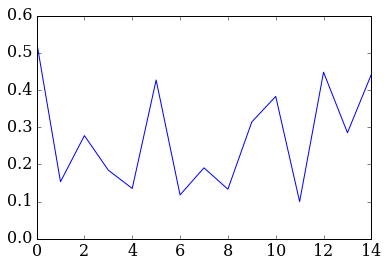

In [28]:
# plt.plot(pca_asyms[0][2,:])
plt.plot(cluster_asyms[0])
# [len(cluster_asyms[ii])==pca_asyms[ii].shape[0] for ii in range(len(cluster_asyms))]

In [7]:
denoised_cors.shape

(22, 133)

In [10]:
# np.save('ALFbuf_kmeans_pca_run%d.npy'%run_num, denoised_cors)

In [35]:
denoised_cors =[]
pca_num = []
pca_asyms =[]
cluster_asyms = []
for qidx in range(10,32):
    ##### comput asymetries of cluster average
#     print qidx
    cluster_nums =sorted([ int(key.split('_')[-1]) for key in f['q%d'%qidx].keys() if key.startswith('norm')])
    asym_kmeans = f['q%d'%qidx]['asym'].value
    cluster_asyms.append(asym_kmeans)
    all_asym=[]
    for jj,kk in enumerate(cluster_nums):
#         print kk
        asym=[asym_kmeans[jj]]
        for ii in range(1,15):
            try:
                cc= f_eig['q%d'%qidx]['k%d'%kk]['pca%d'%ii][0,phi_offset:num_phi/2-phi_offset]
                nc=normalize(cc)
                asym.append( (np.abs(nc-nc[::-1])).mean() )
            except:
                asym.append(10000)
        all_asym.append(asym)
    all_asym=np.array(all_asym)
    pca_asyms.append(all_asym)
    ##### use the minimum asymmetry to decide what pcs components to remove for each cluster
    remove=all_asym.argmin(-1)

    ave_cor =None
    num_shots=0
    for jj,kk in enumerate(cluster_nums):
        if all_asym[jj][remove[jj]]<0.2:
            if remove[jj]>1:
        #         cc= f_eig['q%d'%qidx]['k%d'%kk]['pca2'][0,phi_offset:num_phi/2-phi_offset]
                cc= f_eig['q%d'%qidx]['k%d'%kk]['pca%d'%remove[jj]][0,phi_offset:num_phi/2-phi_offset]
            elif remove[jj]==1:
                cc= f_eig['q%d'%qidx]['k%d'%kk]['pca1'][0,phi_offset:num_phi/2-phi_offset]

            else:
                cc=f['q%d'%qidx]['ave_clus_cor'][jj,phi_offset:num_phi/2-phi_offset]

            nshots=f['q%d'%qidx]['clus_nshots'][jj]
            if ave_cor is None:
                ave_cor=cc*nshots
            else:
                ave_cor+=cc*nshots
            num_shots+=nshots
        else: 
            continue
    #### average cor after pca remove
    ave_cor/=num_shots
    
    denoised_cors.append(ave_cor)
    pca_num.append(remove)
    print num_shots
denoised_cors=np.array(denoised_cors)
pca_num = np.array(pca_num)
# pca_asyms = np.array(pca_asyms)
print denoised_cors.shape,pca_num.shape
print num_shots

68772
76100
45366
79634
65240
72522
98314
76810
82996
61316
78912
71450
68886
81380
90444
106824
113368
113372
113372
86276
106746
101002
(22, 133) (22,)
101002


In [36]:
all_asym.shape
remove.shape

(15,)

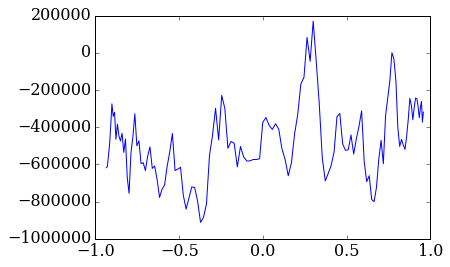

In [60]:
ii=21
plt.plot(exp_cpsi[10+ii],denoised_cors[ii])

In [ ]:
# np.save('ALFbuf_kmeans_pca_run%d.npy'%run_num, denoised_cors)